# **USAD 모델 구현 코드**

데이터셋 설정
- 학습셋: 정상 데이터만 사용
- 테스트셋: 불량 데이터만 사용

전처리 방법
- 각 Wafer_ID의 센서 데이터를 100단위로 끊어서 Sequence를 생성 (Sliding Window 적용)
- MinMax Scaling 적용

## **0. 드라이브 연결**

In [ ]:
from google.colab import drive
import os


drive.mount('/content/drive')

Mounted at /content/drive


## **1. 파라미터 설정 및 데이터 로드, 데이터셋 구현**

In [ ]:
# ==========================================
# 1. 라이브러리 임포트 및 설정
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import os

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==========================================
# 2. 데이터 로드
# ==========================================
# 업로드된 파일명 사용 (환경에 맞게 경로 수정 가능)
file_path = "/content/drive/MyDrive/ASK_2026_FDC/Dataset/MACHINE_Data.xlsx"

if os.path.exists(file_path):
    print(f"Loading data from: {file_path}")
    if file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path)
    else:
        df = pd.read_csv(file_path)
else:
    print("파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    # 임시 빈 데이터프레임 생성 (에러 방지용)
    df = pd.DataFrame()

# 센서 컬럼 정의 (기존 코드 기준)
sensor_cols = [
    'BCl3 Flow', 'Cl2 Flow', 'RF Btm Pwr', 'RF Btm Rfl Pwr', 'Endpt A',
    'He Press', 'Pressure', 'RF Tuner', 'RF Load', 'RF Phase Err',
    'RF Pwr', 'RF Impedance', 'TCP Tuner', 'TCP Phase Err',
    'TCP Impedance', 'TCP Top Pwr', 'TCP Rfl Pwr', 'TCP Load', 'Vat Valve'
]

# ==========================================
# 3. 데이터 전처리 함수 (기존 코드 유지)
# ==========================================
def preprocess_sensor_data(raw_data, seq_len=100):
    """
    논문 방식 전처리:
    1. MinMaxScaler를 이용한 0~1 정규화
    2. Sliding Window를 통한 시각(Time-step) 데이터 생성
    """
    if len(raw_data) == 0:
        return np.array([]), None

    # 정규화
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(raw_data)

    # 시퀀스 생성
    sequences = []
    for i in range(len(scaled_data) - seq_len + 1):
        sequences.append(scaled_data[i:i + seq_len])

    return np.array(sequences), scaler

# ==========================================
# 4. 데이터셋 구성
# ==========================================
experiments = ['l29', 'l31', 'l33']
datasets = {}

print("\n--- Preprocessing Data ---")
for exp_id in experiments:
    # 해당 실험 데이터 추출
    exp_df = df[df['Wafer_ID'].str.contains(exp_id, case=False, na=False)]

    if exp_df.empty:
        continue

    # 라벨 분리
    train_df = exp_df[exp_df['Label'] == 'Normal']
    test_fault_df = exp_df[exp_df['Label'] == 'Fault']

    if len(train_df) < 100:
        continue

    train_raw = train_df[sensor_cols].values
    test_fault_raw = test_fault_df[sensor_cols].values if not test_fault_df.empty else np.array([])

    # Train 데이터 전처리
    X_train, scaler = preprocess_sensor_data(train_raw, seq_len=100)

    # Test Fault 데이터 전처리
    X_test_fault = []
    if len(test_fault_raw) >= 100:
        scaled_fault = scaler.transform(test_fault_raw)
        for i in range(len(scaled_fault) - 100 + 1):
            X_test_fault.append(scaled_fault[i:i + 100])
        X_test_fault = np.array(X_test_fault)
    else:
        X_test_fault = np.array([])

    datasets[exp_id] = {
        'train': X_train,
        'test_normal': X_train,
        'test_fault': X_test_fault,
        'scaler': scaler
    }
    print(f"[{exp_id}] Train: {X_train.shape}, Fault: {X_test_fault.shape}")

Using device: cpu
Loading data from: /content/drive/MyDrive/ASK_2026_FDC/Dataset/MACHINE_Data.xlsx

--- Preprocessing Data ---
[l29] Train: (3387, 100, 19), Fault: (814, 100, 19)
[l31] Train: (3539, 100, 19), Fault: (443, 100, 19)
[l33] Train: (3547, 100, 19), Fault: (505, 100, 19)


## **2. 모델 및 함수 정의**

In [ ]:
# ==========================================
# 5. USAD 모델 및 유틸리티 정의 (수정됨)
# ==========================================
class USAD(nn.Module):
    def __init__(self, w_size, z_size):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(w_size, w_size // 2),
            nn.ReLU(True),
            nn.Linear(w_size // 2, w_size // 4),
            nn.ReLU(True),
            nn.Linear(w_size // 4, z_size),
            nn.ReLU(True)
        )
        # Decoder 1
        self.decoder1 = nn.Sequential(
            nn.Linear(z_size, w_size // 4),
            nn.ReLU(True),
            nn.Linear(w_size // 4, w_size // 2),
            nn.ReLU(True),
            nn.Linear(w_size // 2, w_size),
            nn.Sigmoid()
        )
        # Decoder 2
        self.decoder2 = nn.Sequential(
            nn.Linear(z_size, w_size // 4),
            nn.ReLU(True),
            nn.Linear(w_size // 4, w_size // 2),
            nn.ReLU(True),
            nn.Linear(w_size // 2, w_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1)) # Adversarial path
        return w1, w2, w3

def train_usad(model, train_loader, optimizer, n_epochs):
    model.train()
    for epoch in range(n_epochs):
        for [batch] in train_loader:
            batch = batch.to(device)
            # Flatten input for USAD (Batch, Seq, Feat) -> (Batch, Seq*Feat)
            batch = batch.view(batch.size(0), -1)

            w1, w2, w3 = model(batch)

            # USAD Loss
            loss1 = 1 / (epoch + 1) * torch.mean((batch - w1)**2) + (1 - 1 / (epoch + 1)) * torch.mean((batch - w3)**2)
            loss2 = 1 / (epoch + 1) * torch.mean((batch - w2)**2) - (1 - 1 / (epoch + 1)) * torch.mean((batch - w3)**2)

            loss = loss1 + loss2
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

def evaluate_usad(model, data_loader, alpha=0.5, beta=0.5):
    model.eval()
    results = []
    with torch.no_grad():
        for [batch] in data_loader:
            batch = batch.to(device)
            batch_flat = batch.view(batch.size(0), -1)

            w1, w2, w3 = model(batch_flat)

            diff1 = torch.mean((batch_flat - w1)**2, axis=1)
            diff2 = torch.mean((batch_flat - w3)**2, axis=1)
            score = alpha * diff1 + beta * diff2
            results.append(score)
    return torch.cat(results).cpu().numpy()

def plot_model_results(exp_id, title, y_true, y_pred, ai_scores, threshold):
    # 결과 시각화 함수 (기존 코드 유지)
    plt.figure(figsize=(18, 5))

    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Fault'], yticklabels=['Normal', 'Fault'])
    plt.title(f'[{exp_id}] {title} CM')

    # 2. Score Distribution
    plt.subplot(1, 3, 2)
    indices = np.arange(len(ai_scores))
    n_norm = sum(y_true) # y_true: Normal=1, Fault=0
    plt.scatter(indices[:n_norm], ai_scores[:n_norm], c='b', label='Normal', alpha=0.5, s=10)
    plt.scatter(indices[n_norm:], ai_scores[n_norm:], c='r', marker='x', label='Fault', s=10)
    plt.axhline(y=threshold, color='k', linestyle='--', label='Threshold')
    plt.title('Anomaly Scores')
    plt.legend()

    # 3. ROC Curve
    # ROC 계산을 위해 Fault=1, Normal=0으로 일시 변환
    y_true_roc = [1 if y == 0 else 0 for y in y_true]
    fpr, tpr, _ = roc_curve(y_true_roc, ai_scores)
    roc_auc = auc(fpr, tpr)

    plt.subplot(1, 3, 3)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    acc = accuracy_score(y_true, y_pred)
    print(f"👉 {title} Accuracy: {acc*100:.2f}%, AUC: {roc_auc:.4f}")
    return acc, roc_auc

## **3. 메인 코드 실행**


--- Starting Experiments with USAD ---


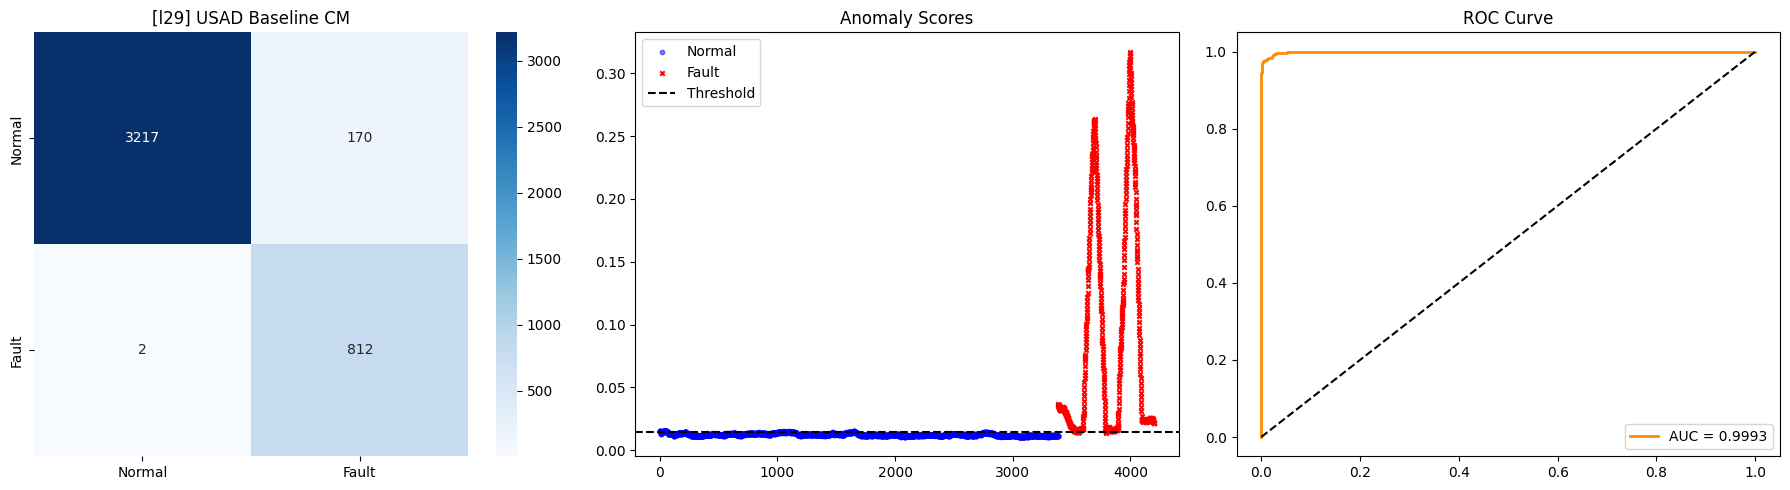

👉 USAD Baseline Accuracy: 95.91%, AUC: 0.9993
[l29] Cleaned Data: 3387 -> 3317


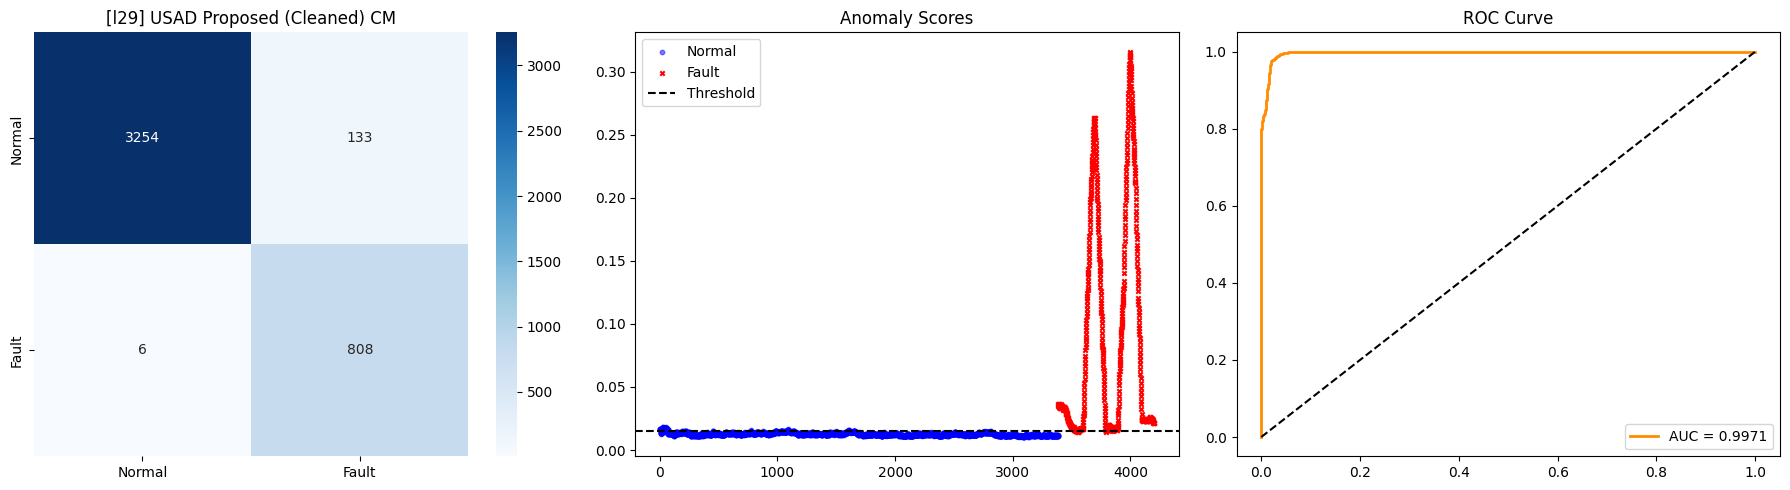

👉 USAD Proposed (Cleaned) Accuracy: 96.69%, AUC: 0.9971


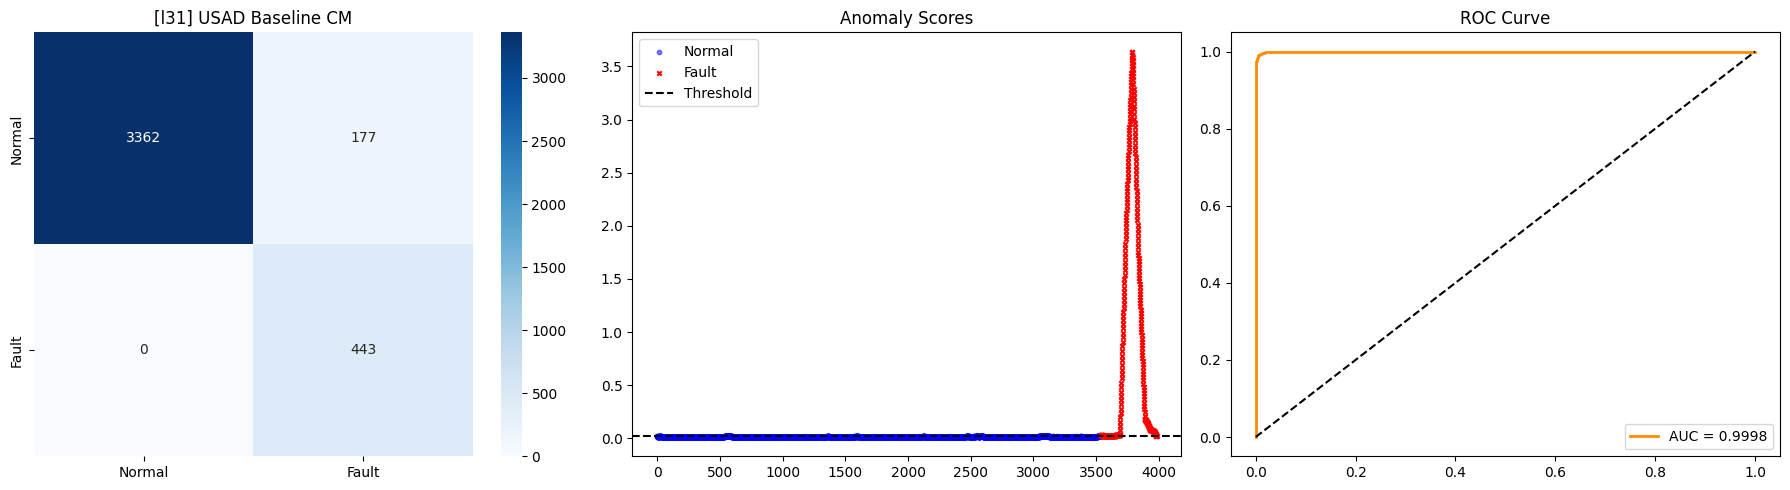

👉 USAD Baseline Accuracy: 95.55%, AUC: 0.9998
[l31] Cleaned Data: 3539 -> 3499


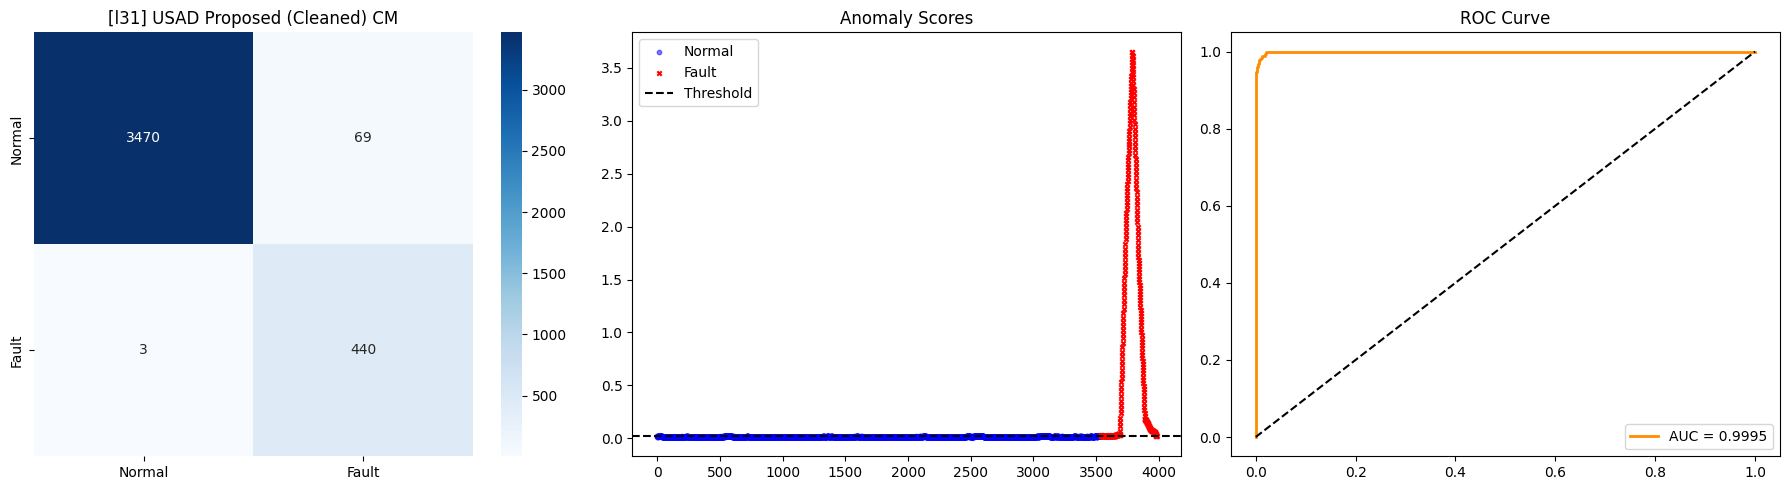

👉 USAD Proposed (Cleaned) Accuracy: 98.19%, AUC: 0.9995


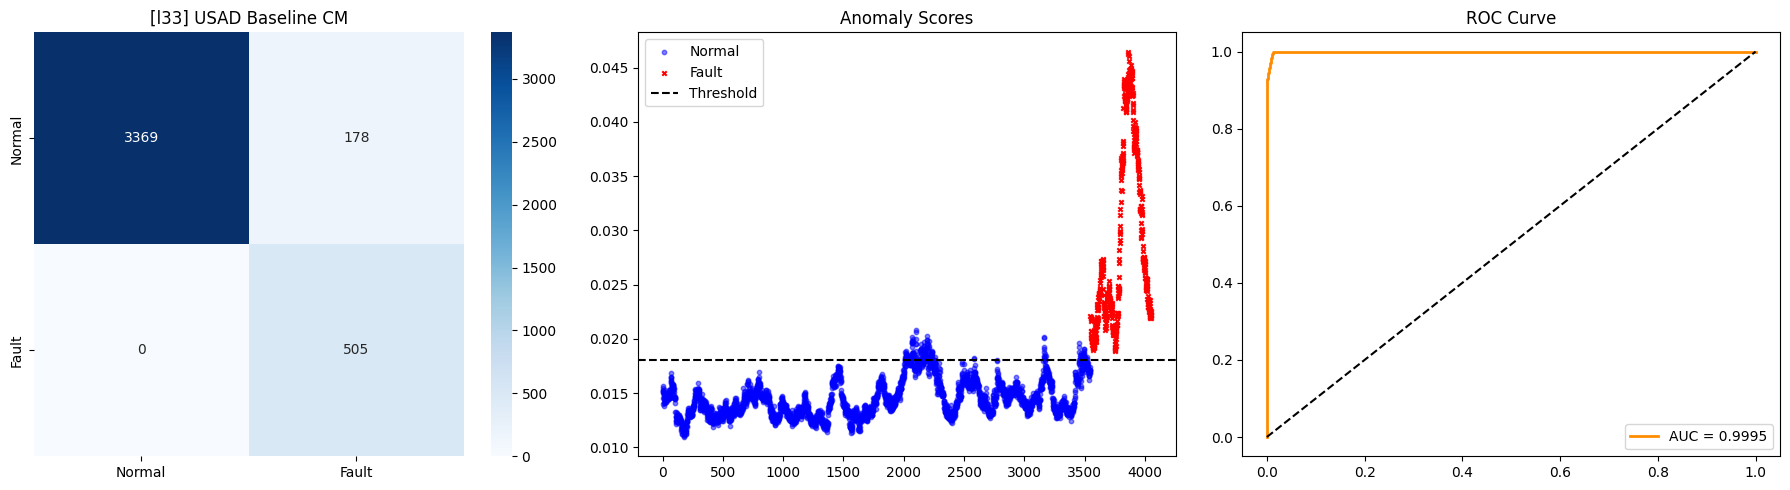

👉 USAD Baseline Accuracy: 95.61%, AUC: 0.9995
[l33] Cleaned Data: 3547 -> 3507


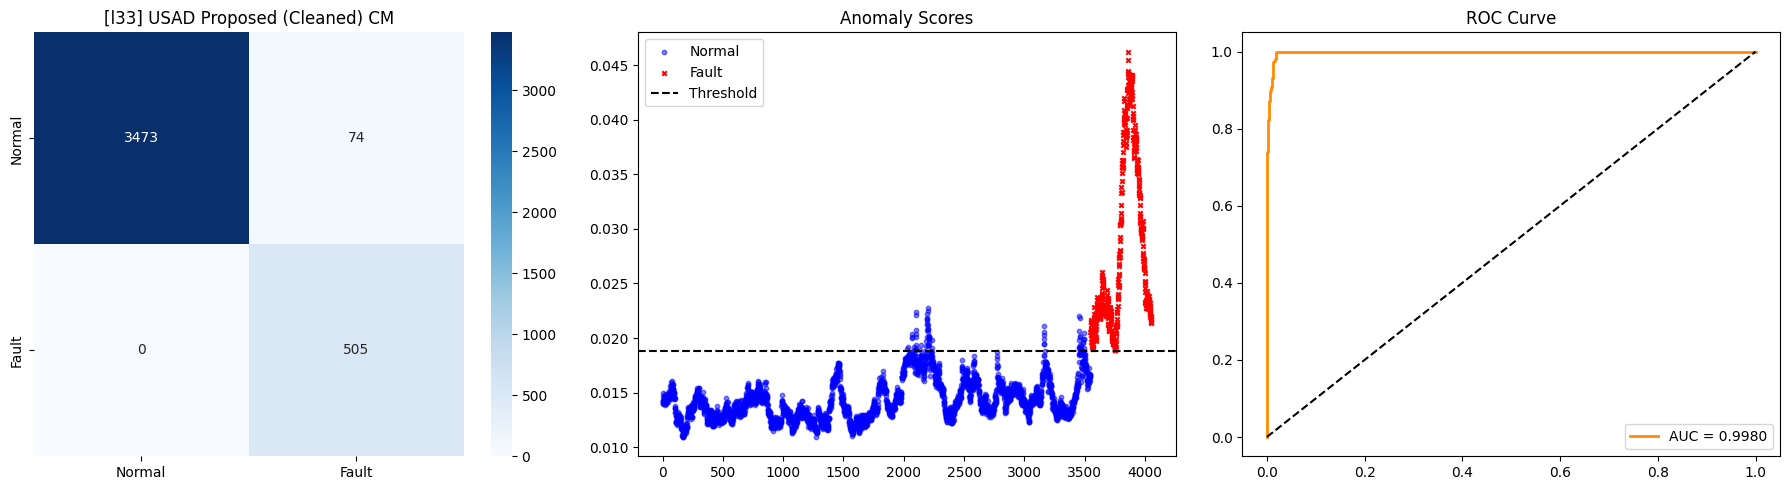

👉 USAD Proposed (Cleaned) Accuracy: 98.17%, AUC: 0.9980

--- Final Results ---
   Exp  Base_Acc  Base_AUC   Pro_Acc   Pro_AUC  Improve_AUC
0  l29  0.959057  0.999316  0.966913  0.997142    -0.002173
1  l31  0.955550  0.999803  0.981919  0.999513    -0.000290
2  l33  0.956071  0.999514  0.981737  0.998035    -0.001479


In [ ]:
# ==========================================
# 6. 메인 실험 루프 (USAD 적용)
# ==========================================
comparison_table = []
exp_configs = {
    'l29': {'clean_p': 98, 'thresh_p': 98, 'epochs': 50}, # USAD는 학습이 빨라 에폭 조절 가능
    'l31': {'clean_p': 99, 'thresh_p': 99, 'epochs': 50},
    'l33': {'clean_p': 99, 'thresh_p': 99, 'epochs': 50}
}

print("\n--- Starting Experiments with USAD ---")

if datasets:
    sample_exp = list(datasets.keys())[0]
    n_steps = datasets[sample_exp]['train'].shape[1]
    n_feats = datasets[sample_exp]['train'].shape[2]
    # USAD 입력 차원: Flattened size
    input_dim = n_steps * n_feats
    latent_dim = 40 # 논문 권장값 or 튜닝 가능

    for exp_id in experiments:
        if exp_id not in datasets: continue

        conf = exp_configs[exp_id]
        X_train_raw = datasets[exp_id]['train']
        X_test_normal = datasets[exp_id]['test_normal']
        X_test_fault = datasets[exp_id]['test_fault']

        # Test Set 구성 (Normal=1, Fault=0)
        y_true = [1] * len(X_test_normal) + [0] * len(X_test_fault)
        X_test_all = np.concatenate([X_test_normal, X_test_fault], axis=0)

        # DataLoader 생성
        train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train_raw)), batch_size=32, shuffle=True)
        test_loader = DataLoader(TensorDataset(torch.FloatTensor(X_test_all)), batch_size=32, shuffle=False)

        # --- [Case A] Baseline (USAD) ---
        model_base = USAD(w_size=input_dim, z_size=latent_dim).to(device)
        opt_base = optim.Adam(model_base.parameters(), lr=1e-3)

        # 학습
        train_usad(model_base, train_loader, opt_base, n_epochs=conf['epochs'])

        # 추론 및 임계값 설정
        ai_scores_train = evaluate_usad(model_base, DataLoader(TensorDataset(torch.FloatTensor(X_train_raw)), batch_size=32))
        thresh_base = np.percentile(ai_scores_train, 95) # 95% 분위수

        ai_scores_test = evaluate_usad(model_base, test_loader)
        pred_base = [0 if s > thresh_base else 1 for s in ai_scores_test] # Score > Thresh -> Fault(0)

        acc_base, auc_base = plot_model_results(exp_id, "USAD Baseline", y_true, pred_base, ai_scores_test, thresh_base)

        # --- [Case B] Proposed (USAD + Cleaning) ---
        # K-Fold를 이용해 학습 데이터의 이상치(Noise) 제거 후 재학습
        kf = KFold(n_splits=5, shuffle=True, random_state=42) # 시간 절약을 위해 5-Fold
        bad_indices = []

        # Cleaning 단계
        for t_idx, v_idx in kf.split(X_train_raw):
            temp_model = USAD(w_size=input_dim, z_size=latent_dim).to(device)
            temp_opt = optim.Adam(temp_model.parameters(), lr=1e-3)
            temp_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train_raw[t_idx])), batch_size=32, shuffle=True)

            # 짧게 학습
            train_usad(temp_model, temp_loader, temp_opt, n_epochs=10)

            # Validation Set Score 계산
            val_scores = evaluate_usad(temp_model, DataLoader(TensorDataset(torch.FloatTensor(X_train_raw[v_idx])), batch_size=32))

            # 이상치 인덱스 수집
            bad_indices.extend(v_idx[val_scores > np.percentile(val_scores, conf['clean_p'])])

        # 정제된 데이터 생성
        X_train_clean = np.delete(X_train_raw, list(set(bad_indices)), axis=0)
        print(f"[{exp_id}] Cleaned Data: {len(X_train_raw)} -> {len(X_train_clean)}")

        # 정제된 데이터로 최종 학습
        model_pro = USAD(w_size=input_dim, z_size=latent_dim).to(device)
        opt_pro = optim.Adam(model_pro.parameters(), lr=1e-3)
        clean_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train_clean)), batch_size=32, shuffle=True)

        train_usad(model_pro, clean_loader, opt_pro, n_epochs=conf['epochs'])

        # 추론
        ai_scores_train_pro = evaluate_usad(model_pro, DataLoader(TensorDataset(torch.FloatTensor(X_train_clean)), batch_size=32))
        thresh_pro = np.percentile(ai_scores_train_pro, conf['thresh_p'])

        ai_scores_test_pro = evaluate_usad(model_pro, test_loader)
        pred_pro = [0 if s > thresh_pro else 1 for s in ai_scores_test_pro]

        acc_pro, auc_pro = plot_model_results(exp_id, "USAD Proposed (Cleaned)", y_true, pred_pro, ai_scores_test_pro, thresh_pro)

        # 결과 저장
        comparison_table.append({
            'Exp': exp_id,
            'Base_Acc': acc_base,
            'Base_AUC': auc_base,
            'Pro_Acc': acc_pro,
            'Pro_AUC': auc_pro,
            'Improve_AUC': auc_pro - auc_base
        })

# 결과 출력
print("\n--- Final Results ---")
res_df = pd.DataFrame(comparison_table)
print(res_df)